## ALBERTO CASTELLANO MACIAS (100414242)

## MOHAMED AFIF CHIFAOUI (100452024)

## 1. IMPORTS

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.enabled = False

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
from shutil import copyfile
from google.colab import drive
import os, sys
drive.mount('/content/drive')
copyfile('/content/drive/My Drive/AUDIO/LS4/db1.zip', './db1.zip') #Copy db files to our working folder
copyfile('/content/drive/My Drive/AUDIO/LS4/db2.zip', './db2.zip')

Mounted at /content/drive


'./db2.zip'

In [4]:
import zipfile
zipPath='./db1.zip' #path of the 1st zip file
dataFolder='./data' #We extract files to the current folder
with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(dataFolder)

zipPath='./db2.zip' #path of the 2nd zip file
dataFolder='./data' # We extract files to the current folder
with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(dataFolder)

## 2. DATA VISUALIZATION

In [5]:
db = pd.read_csv('data/dermoscopyDBtrain.csv',header=0,dtype={'id': str, 'label': int})

#We show inform
n = 535
img_id = db.id[535]
label = db.label[535]


print('Image ID: {}'.format(img_id))
print('Label: {}'.format(label))

Image ID: 0536
Label: 0


In [6]:
print(len(db))

2000


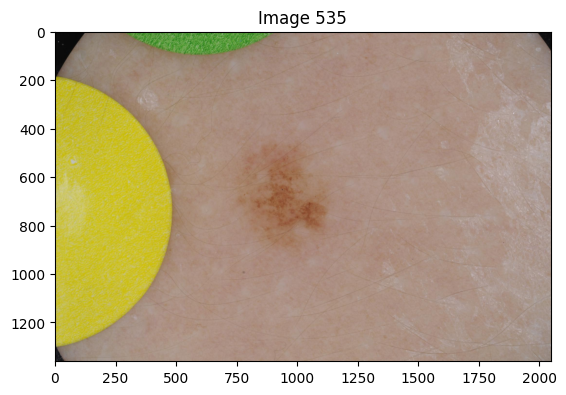

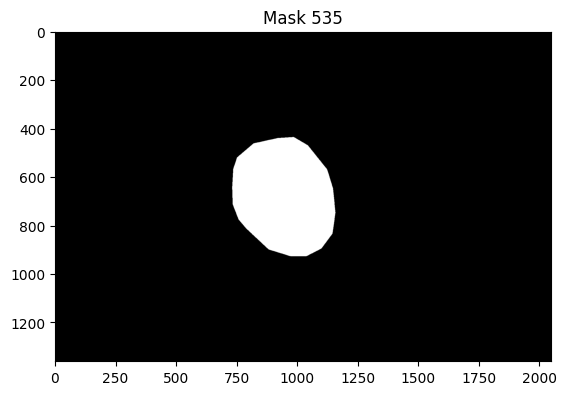

In [7]:
def imshow(image, title_str):
    if len(image.shape)>2:
        plt.imshow(image)
    else:
        plt.imshow(image,cmap=plt.cm.gray)
    plt.title(title_str)

plt.figure()
imshow(io.imread(os.path.join('data/images/', img_id + '.jpg' )),'Image %d'%n)
plt.figure()
imshow(io.imread(os.path.join('data/masks/', img_id + '.png')),'Mask %d'%n)

plt.show()

In [8]:
class DermoscopyDataset(Dataset):
    """Dermoscopy dataset."""

    def __init__(self, csv_file, root_dir,transform=None,  maxSize=0):
        """
        Args:
            csv_file (string): Path al fichero csv con las anotaciones.
            root_dir (string): Directorio raíz donde encontraremos las carpetas 'images' y 'masks' .
            transform (callable, optional): Transformaciones opcionales a realizar sobre las imágenes.
        """
        self.dataset = pd.read_csv(csv_file,header=0,dtype={'id': str, 'label': int})

        if maxSize>0:
            newDatasetSize=maxSize #maxSize muestras
            idx=np.random.RandomState(seed=42).permutation(range(len(self.dataset)))
            reduced_dataset=self.dataset.iloc[idx[0:newDatasetSize]]
            self.dataset=reduced_dataset.reset_index(drop=True)

        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir,'images')
        self.mask_dir = os.path.join(root_dir,'masks')
        self.transform = transform
        self.classes = ['nevus', 'melanoma', 'keratosis']
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #Leemos la imagen
        img_name = os.path.join(self.img_dir,self.dataset.id[idx] + '.jpg')
        image = io.imread(img_name)
        #Leemos la máscara
        mask_name = os.path.join(self.mask_dir,self.dataset.id[idx] + '.png')
        mask = io.imread(mask_name)

        sample = {'image': image, 'mask': mask, 'label':  self.dataset.label[idx].astype(dtype=np.long)}
        if self.transform:
            sample = self.transform(sample)
        return sample

0 (767, 1022, 3) 0
1 (767, 1022, 3) 0
2 (767, 1022, 3) 1
3 (767, 1022, 3) 0


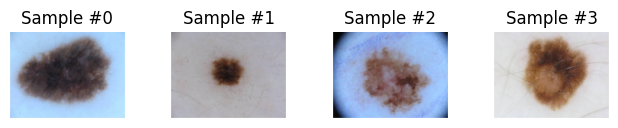

In [9]:
train_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtrain.csv',
                                    root_dir='data')

fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]
    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

## 3. TRANSFORMATIONS

In [10]:
class CropByMask(object):
    """Crop the image using the lesion mask.

    Args:
        border (tuple or int): Border surrounding the mask. We dilate the mask as the skin surrounding
        the lesion is important for dermatologists.
        If it is a tuple, then it is (bordery,borderx)
    """

    def __init__(self, border):
        assert isinstance(border, (int, tuple))
        if isinstance(border, int):
            self.border = (border,border)
        else:
            self.border = border

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        h, w = image.shape[:2]
        #Compute the coordinates of the bounding box that contains the mask
        sidx=np.nonzero(mask)
        minx=np.maximum(sidx[1].min()-self.border[1],0)
        maxx=np.minimum(sidx[1].max()+1+self.border[1],w)
        miny=np.maximum(sidx[0].min()-self.border[0],0)
        maxy=np.minimum(sidx[0].max()+1+self.border[1],h)
        #Crop the image
        image=image[miny:maxy,minx:maxx,...]
        mask=mask[miny:maxy,minx:maxx]

        return {'image': image, 'mask': mask, 'label' : label}

class Rescale(object):
    """Re-scale image to a predefined size.

    Args:
        output_size (tuple or int): The desired size. If it is a tuple, output is the output_size.
        If it is an int, the smallest dimension will be the output_size
            a we will keep fixed the original aspect ratio.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        msk = transform.resize(mask, (new_h, new_w))

        return {'image': img, 'mask': msk, 'label' : label}

class RandomCrop(object):
    """Randomly crop the image.

    Args:
        output_size (tuple or int): Crop size. If  int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        if h>new_h:
            top = np.random.randint(0, h - new_h)
        else:
            top=0

        if w>new_w:
            left = np.random.randint(0, w - new_w)
        else:
            left = 0

        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'mask': mask, 'label': label}

class CenterCrop(object):
    """Crop the central area of the image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        rem_h = h - new_h
        rem_w = w - new_w

        if h>new_h:
            top = int(rem_h/2)
        else:
            top=0

        if w>new_w:
            left = int(rem_w/2)
        else:
            left = 0

        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'mask': mask, 'label': label}


class ToTensor(object):
    """Convert ndarrays into pytorch tensors."""

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        # Cambiamos los ejes
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        # A la máscara le añadimos una dim fake al principio
        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze(0)
        label=torch.tensor(label,dtype=torch.long)

        return {'image':image,
                'mask':mask,
                'label':label}

class Normalize(object):
    """Normalize data by subtracting means and dividing by standard deviations.

    Args:
        mean_vec: Vector with means.
        std_vec: Vector with standard deviations.
    """

    def __init__(self, mean,std):

        assert len(mean)==len(std),'Length of mean and std vectors is not the same'
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        c, h, w = image.shape
        assert c==len(self.mean), 'Length of mean and image is not the same'
        dtype = image.dtype
        mean = torch.as_tensor(self.mean, dtype=dtype, device=image.device)
        std = torch.as_tensor(self.std, dtype=dtype, device=image.device)
        image.sub_(mean[:, None, None]).div_(std[:, None, None])


        return {'image': image, 'mask': mask, 'label' : label}

## 4. ITERATING DATASET

In [11]:
#Pixel means and stds expected by models in torchvision
pixel_mean=[0.485, 0.456, 0.406]
pixel_std=[0.229, 0.224, 0.225]

#Train Dataset
train_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtrain.csv',
                                    root_dir='data',
                                    maxSize=2000, ###IMPORTANT: maxSize=500 to speed-up the training process
                                                 ### Set to 0 or 2000 for training your optimal model
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(256),
                                    RandomCrop(256),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))
#Val dataset
val_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBval.csv',
                                    root_dir='data',
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(256),
                                    RandomCrop(256),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))

#Test dataset
test_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtest.csv',
                                    root_dir='data',
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(256),
                                    RandomCrop(256),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))

for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].size(), sample['label'])

    if i == 3:
        break

0 torch.Size([3, 256, 256]) tensor(2)
1 torch.Size([3, 256, 256]) tensor(1)
2 torch.Size([3, 256, 256]) tensor(0)
3 torch.Size([3, 256, 256]) tensor(0)


0 torch.Size([8, 3, 256, 256]) tensor([1, 0, 0, 0, 1, 0, 1, 0])


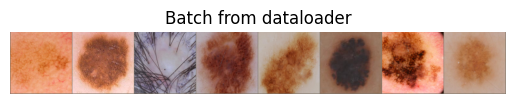

1 torch.Size([8, 3, 256, 256]) tensor([0, 0, 0, 1, 1, 0, 0, 1])


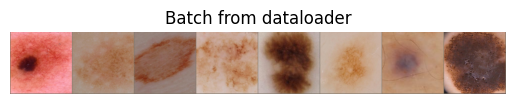

2 torch.Size([8, 3, 256, 256]) tensor([0, 0, 2, 0, 0, 0, 1, 2])


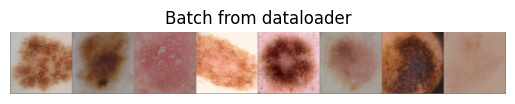

3 torch.Size([8, 3, 256, 256]) tensor([0, 0, 0, 1, 2, 1, 0, 0])


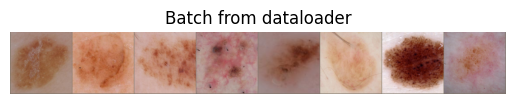

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=8,
                        shuffle=True, num_workers=3)
#Validation dataset => No shuffle
val_dataloader = DataLoader(val_dataset, batch_size=64,
                        shuffle=False, num_workers=3)

#Test Dataset => => No shuffle
test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=False, num_workers=3)


# Auxiliary function to visualize a batch
def show_batch(sample_batched):
    """Mostramos las lesiones de un batch."""
    images_batch, labels_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    #Generamos el grid
    grid = utils.make_grid(images_batch)
    #Lo pasamos a numpy y lo desnormalizamos
    grid=grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'])
    plt.figure()
    show_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()

    #We show the data of the 3rd batch and stop.
    if i_batch == 3:
        break

## 5. CUSTOM NETWORK

In [15]:
class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()

        # Define the layers of your network
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization
        self.relu1 = nn.ReLU() # Relu activation
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) #Maxpooling

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # We added an additional convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # We removed a linear layer and ended up with just 2
        self.fc1 = nn.Linear(64 * 32 * 32, 120)
        self.bn4 = nn.BatchNorm1d(120)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5) # Dropout of 0.5
        self.fc2 = nn.Linear(120, 3)  # 3 output classes

    def forward(self, x):
        # Forward pass
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)


        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [16]:
customNet = CustomNetwork() #we initialize the network
customNet.to(device) #copy the network to the device (gpu)
#Sample a batch of data and get images and labels
data=next(iter(train_dataloader))
inputs = data['image'].to(device).float()
labels = data['label'].to(device)

batchSize = labels.shape
print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

#Lo pasamos por la red
with torch.set_grad_enabled(False):
    outputs = customNet(inputs)
    print('Size of the output tensor is {}'.format(outputs.shape))

Size of tensor containing a batch of images is torch.Size([8, 3, 256, 256])
Size of the output tensor is torch.Size([8, 3])


## 6. TRAINING AND EVALUATION

In [13]:
def computeAUCs(scores,labels):

    aucs = np.zeros((2,))
    #Calculamos el AUC melanoma vs all
    scores_mel = scores[:,1]
    labels_mel = (labels == 1).astype(np.int)
    aucs[0]=metrics.roc_auc_score(labels_mel, scores_mel)

    #Calculamos el AUC queratosis vs all
    scores_sk = scores[:,2]
    labels_sk = (labels == 2).astype(np.int)
    aucs[1]=metrics.roc_auc_score(labels_sk, scores_sk)

    return aucs

In [17]:
#Loss function
criterion = nn.CrossEntropyLoss()

# SGD with momentum
optimizer_ft = optim.SGD(customNet.parameters(), lr=1e-3, momentum=0.9)

# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
#train_model parameters are the network (model), the criterion (loss),
# the optimizer, a learning scheduler (una estrategia de lr strategy), and the training epochs
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    numClasses = len(image_datasets['train'].classes)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_aucs = np.zeros((2,)) #AUCs melanoma vs all, and keratosis
    best_auc = 0
    best_epoch = -1

    #Loop of epochs (each iteration involves train and val datasets)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)



        # Cada época tiene entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in val mode (no grads)


            #Dataset size
            numSamples = dataset_sizes[phase]

            # Create variables to store outputs and labels
            outputs_m=np.zeros((numSamples,numClasses),dtype=np.float)
            labels_m=np.zeros((numSamples,),dtype=np.int)
            running_loss = 0.0

            contSamples=0

            # Iterate (loop of batches)
            for sample in dataloaders[phase]:
                inputs = sample['image'].to(device).float()
                labels = sample['label'].to(device)


                #Batch Size
                batchSize = labels.shape[0]

                # Set grads to zero
                optimizer.zero_grad()

                # Forward
                # Register ops only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward & parameters update only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Accumulate the running loss
                running_loss += loss.item() * inputs.size(0)

                #Apply a softmax to the output
                outputs=F.softmax(outputs.data,dim=1)
                # Store outputs and labels
                outputs_m [contSamples:contSamples+batchSize,...]=outputs.cpu().numpy()
                labels_m [contSamples:contSamples+batchSize]=labels.cpu().numpy()
                contSamples+=batchSize

            #At the end of an epoch, update the lr scheduler
            if phase == 'train':
                scheduler.step()

            #Accumulated loss by epoch
            epoch_loss = running_loss / dataset_sizes[phase]

            #Compute the AUCs at the end of the epoch
            aucs=computeAUCs(outputs_m,labels_m)

            #And the Average AUC
            epoch_auc = aucs.mean()

            print('{} Loss: {:.4f} AUC mel: {:.4f} sk: {:.4f} avg: {:.4f}'.format(
                phase, epoch_loss, aucs[0], aucs[1], epoch_auc))

            # Deep copy of the best model
            if phase == 'val' and epoch_auc > best_auc:
                best_auc = epoch_auc
                best_aucs = aucs.copy()
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best model in epoch {:d} val AUCs: mel {:4f} sk {:4f} avg {:4f}'.format(best_epoch,best_aucs[0],best_aucs[1],best_auc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
image_datasets = {'train' : train_dataset, 'val': val_dataset}

dataloaders = {'train' : train_dataloader, 'val': val_dataloader}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = image_datasets['train'].classes

In [ ]:
random.seed(42)
npr.seed(42)
torch.manual_seed(42)
customNet = train_model(customNet, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=12)

Epoch 0/11
----------
train Loss: 0.8231 AUC mel: 0.5590 sk: 0.7164 avg: 0.6377
val Loss: 0.8937 AUC mel: 0.6439 sk: 0.8117 avg: 0.7278

Epoch 1/11
----------
train Loss: 0.7898 AUC mel: 0.5883 sk: 0.7451 avg: 0.6667
val Loss: 0.8776 AUC mel: 0.7108 sk: 0.8111 avg: 0.7610

Epoch 2/11
----------
train Loss: 0.7604 AUC mel: 0.6047 sk: 0.7842 avg: 0.6944
val Loss: 0.8633 AUC mel: 0.6178 sk: 0.8175 avg: 0.7176

Epoch 3/11
----------
train Loss: 0.7521 AUC mel: 0.6148 sk: 0.7926 avg: 0.7037
val Loss: 0.8483 AUC mel: 0.6928 sk: 0.8479 avg: 0.7703

Epoch 4/11
----------
train Loss: 0.7230 AUC mel: 0.6372 sk: 0.8292 avg: 0.7332
val Loss: 0.8281 AUC mel: 0.7239 sk: 0.8560 avg: 0.7900

Epoch 5/11
----------
train Loss: 0.7433 AUC mel: 0.6268 sk: 0.8055 avg: 0.7162
val Loss: 0.8347 AUC mel: 0.7061 sk: 0.8772 avg: 0.7917

Epoch 6/11
----------
train Loss: 0.7245 AUC mel: 0.6516 sk: 0.8246 avg: 0.7381
val Loss: 0.8803 AUC mel: 0.6456 sk: 0.8569 avg: 0.7512

Epoch 7/11
----------
train Loss: 0.6910 

Plot results:

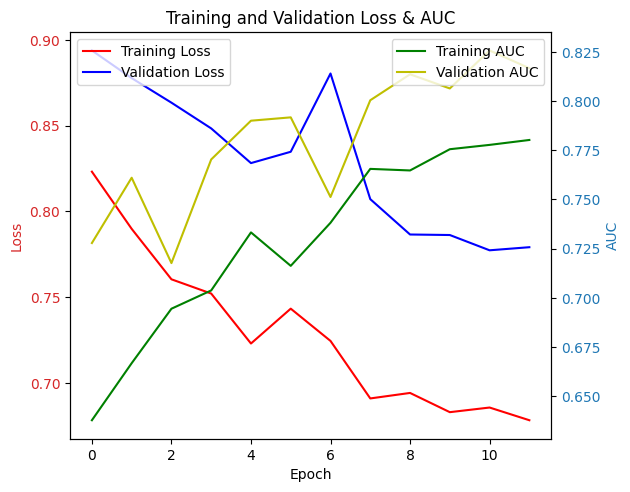

In [2]:
import matplotlib.pyplot as plt

def plot_training_history(loss_history, auc_history, num_epochs):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(range(num_epochs), loss_history['train'], label='Training Loss', color='r')
    ax1.plot(range(num_epochs), loss_history['val'], label='Validation Loss', color='b')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()

    color = 'tab:blue'
    ax2.set_ylabel('AUC', color=color)
    ax2.plot(range(num_epochs), auc_history['train'], label='Training AUC', color='g')
    ax2.plot(range(num_epochs), auc_history['val'], label='Validation AUC', color='y')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.title('Training and Validation Loss & AUC')
    plt.show()


loss_history = {'train': [0.8231, 0.7898, 0.7604, 0.7521, 0.7230, 0.7433, 0.7245, 0.6910, 0.6942, 0.6830, 0.6857, 0.6783], 'val': [0.8937, 0.8776, 0.8633, 0.8483, 0.8281, 0.8347, 0.8803, 0.8071, 0.7865, 0.7862, 0.7773, 0.7791]}
auc_history = {'train': [0.6377, 0.6667, 0.6944, 0.7037, 0.7332, 0.7162, 0.7381, 0.7655, 0.7647, 0.7755, 0.7777, 0.7802], 'val': [0.7278, 0.7610, 0.7176, 0.7703, 0.7900, 0.7917, 0.7512, 0.8004, 0.8136, 0.8064, 0.8257, 0.8167]}
num_epochs = len(loss_history['train'])
plot_training_history(loss_history, auc_history, num_epochs)

In [26]:
### Code that generates the test matrix
def test_model(model):
    since = time.time()

    numClasses = len(test_dataset.classes)

    model.eval()   # Ponemos el modelo en modo evaluación

    #Tamaño del dataset
    numSamples = len(test_dataset)

    # Creamos las variables que almacenarán las salidas y las etiquetas
    outputs_m=np.zeros((numSamples,numClasses),dtype=np.float)
    labels_m=np.zeros((numSamples,),dtype=np.int)
    contSamples=0

    # Iteramos sobre los datos
    for sample in test_dataloader:
        inputs = sample['image'].to(device).float()


        #Tamaño del batch
        batchSize = inputs.shape[0]

        # Paso forward
        with torch.torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            #Aplicamos un softmax a la salida
            outputs=F.softmax(outputs.data,dim=1)
            outputs_m [contSamples:contSamples+batchSize,...]=outputs.cpu().numpy()
            contSamples+=batchSize


    return outputs_m

In [ ]:
outputs=test_model(customNet)

In [ ]:
print(outputs)

[[0.48596296 0.20538475 0.30865231]
 [0.58591455 0.27856037 0.13552511]
 [0.34981155 0.35917947 0.29100895]
 ...
 [0.57451439 0.22449514 0.20099047]
 [0.67049712 0.215948   0.11355484]
 [0.73058945 0.13826631 0.13114427]]


In [ ]:
import csv

with open('output_test.csv', mode='w') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',')
    csv_writer.writerows(outputs);

## 7. FINE-TUNING OF A PRE-TRAINED MODEL

### ResNet: second best-performing model (0.9053)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Pre-trained ResNet model
resnet_model = models.resnet50(pretrained=True)

# We will modify the last layer of the network to have 3 output classes
num_classes = 3
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, num_classes)
print(resnet_model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#Loss function
criterion = nn.CrossEntropyLoss()

# SGD with momentum
optimizer_ft = optim.SGD(resnet_model.parameters(), lr=1e-3, momentum=0.9)

# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

resnet_model = train_model(resnet_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/2
----------
train Loss: 0.7582 AUC mel: 0.6716 sk: 0.7782 avg: 0.7249
val Loss: 0.8758 AUC mel: 0.7217 sk: 0.8430 avg: 0.7824

Epoch 1/2
----------
train Loss: 0.6656 AUC mel: 0.7408 sk: 0.8941 avg: 0.8175
val Loss: 0.5942 AUC mel: 0.8575 sk: 0.9530 avg: 0.9053

Epoch 2/2
----------
train Loss: 0.5745 AUC mel: 0.8033 sk: 0.9364 avg: 0.8699
val Loss: 0.7326 AUC mel: 0.7911 sk: 0.9396 avg: 0.8654

Training complete in 7m 18s
Best model in epoch 1 val AUCs: mel 0.857500 sk 0.953042 avg 0.905271


### EfficientNet: best-performing model (0.9158)

In [22]:
import torch
import torch.nn as nn
import pytorchcv
from pytorchcv.model_provider import get_model as ptcv_get_model

# Pre-trained EfficientNet model
effnet_model = ptcv_get_model("efficientnet_b0", pretrained=True)

# # We will modify the last layer of the network to have 3 output classes
num_classes = 3
num_features = effnet_model.output[-1].in_features
effnet_model.output[-1] = nn.Linear(num_features, num_classes)
print(effnet_model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
effnet_model = effnet_model.to(device)

EfficientNet(
  (features): Sequential(
    (init_block): EffiInitBlock(
      (conv): ConvBlock(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): Swish()
      )
    )
    (stage1): Sequential(
      (unit1): EffiDwsConvUnit(
        (dw_conv): ConvBlock(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): Swish()
        )
        (se): SEBlock(
          (pool): AdaptiveAvgPool2d(output_size=1)
          (conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (activ): Swish()
          (conv2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (sigmoid): Sigmoid()
        )
        (pw_conv): ConvBlock(
          (conv): Conv2d(32, 16, kernel_

In [23]:
#Loss function
criterion = nn.CrossEntropyLoss()

# SGD with momentum
optimizer_ft = optim.SGD(effnet_model.parameters(), lr=1e-3, momentum=0.9)

# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [24]:
effnet_model = train_model(effnet_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.7300 AUC mel: 0.6680 sk: 0.8341 avg: 0.7510
val Loss: 0.7169 AUC mel: 0.8244 sk: 0.9226 avg: 0.8735

Epoch 1/9
----------
train Loss: 0.6278 AUC mel: 0.7558 sk: 0.8967 avg: 0.8262
val Loss: 0.6071 AUC mel: 0.8119 sk: 0.9594 avg: 0.8857

Epoch 2/9
----------
train Loss: 0.5454 AUC mel: 0.8114 sk: 0.9403 avg: 0.8758
val Loss: 0.7649 AUC mel: 0.7392 sk: 0.9226 avg: 0.8309

Epoch 3/9
----------
train Loss: 0.4660 AUC mel: 0.8785 sk: 0.9497 avg: 0.9141
val Loss: 0.6836 AUC mel: 0.7983 sk: 0.9601 avg: 0.8792

Epoch 4/9
----------
train Loss: 0.3823 AUC mel: 0.9125 sk: 0.9757 avg: 0.9441
val Loss: 0.5915 AUC mel: 0.8483 sk: 0.9660 avg: 0.9072

Epoch 5/9
----------
train Loss: 0.3625 AUC mel: 0.9235 sk: 0.9722 avg: 0.9479
val Loss: 0.5614 AUC mel: 0.8797 sk: 0.9519 avg: 0.9158

Epoch 6/9
----------
train Loss: 0.3137 AUC mel: 0.9374 sk: 0.9873 avg: 0.9623
val Loss: 0.7282 AUC mel: 0.8378 sk: 0.9422 avg: 0.8900

Epoch 7/9
----------
train Loss: 0.1951 AUC mel:

Plot results:

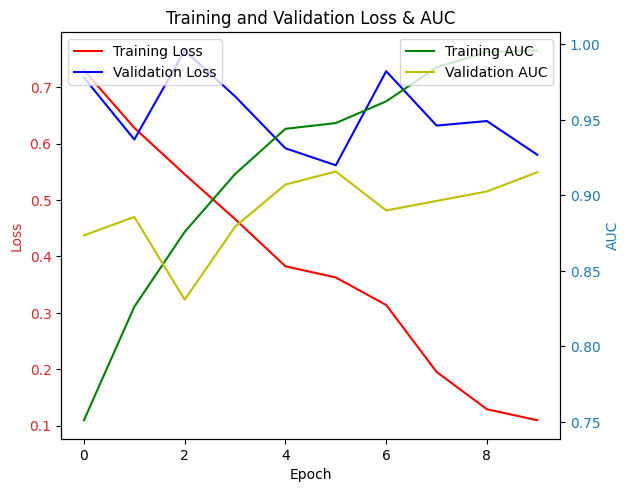

In [33]:
import matplotlib.pyplot as plt

def plot_training_history(loss_history, auc_history, num_epochs):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(range(num_epochs), loss_history['train'], label='Training Loss', color='r')
    ax1.plot(range(num_epochs), loss_history['val'], label='Validation Loss', color='b')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()

    color = 'tab:blue'
    ax2.set_ylabel('AUC', color=color)
    ax2.plot(range(num_epochs), auc_history['train'], label='Training AUC', color='g')
    ax2.plot(range(num_epochs), auc_history['val'], label='Validation AUC', color='y')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.title('Training and Validation Loss & AUC')
    plt.show()


loss_history = {'train': [0.7300, 0.6278, 0.5454, 0.4660, 0.3823, 0.3625, 0.3137, 0.1951, 0.1289, 0.1094],
                'val': [0.7169, 0.6071, 0.7649, 0.6836, 0.5915, 0.5614, 0.7282, 0.6318, 0.6398, 0.5800]}
auc_history = {'train': [0.7510, 0.8262, 0.8758, 0.9141, 0.9441, 0.9479, 0.9623, 0.9848, 0.9950, 0.9960],
               'val': [0.8735, 0.8857, 0.8309, 0.8792, 0.9072, 0.9158, 0.8900, 0.8963, 0.9026, 0.9153]}
num_epochs = len(loss_history['train'])
plot_training_history(loss_history, auc_history, num_epochs)


In [30]:
outputs2=test_model(effnet_model)

In [31]:
print(outputs2)

[[0.80836761 0.13806716 0.05356527]
 [0.01908942 0.97033137 0.01057919]
 [0.93873698 0.02463236 0.03663071]
 ...
 [0.66668868 0.17921671 0.15409459]
 [0.98568165 0.00613566 0.00818279]
 [0.94628495 0.0473672  0.00634782]]


In [32]:
import csv

with open('output_test_ft.csv', mode='w') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',')
    csv_writer.writerows(outputs2);